In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
#import tyssue
import sys
sys.path.append('/home/guillaume/Python/tyssue/src')
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
%matplotlib inline
from scipy import optimize


from tyssue.core.generation import data_dicts
from tyssue.utils.utils import set_data_columns
from tyssue.core.sheet import Sheet

from tyssue.utils.utils import set_data_columns

import tyssue.geometry.sheet_geometry as geom
import tyssue.dynamics.sheet_vertex_model as model
import tyssue.solvers.sheet_vertex_solver as solver

from tyssue.dynamics.sheet_isotropic_model import isotropic_relax



from tyssue.draw.mpl_draw import sheet_view
import tyssue.draw.mpl_draw as draw
from tyssue.io import hdf5

In [3]:
!ls ../leg_joint\ import


before_apoptosis.hf5		  iterate.dat	       small_xml.hf5
default_params.json		  nb_init.py
Import data from leg-joint.ipynb  small_hexagonal.hf5


In [12]:
datasets = hdf5.load_datasets('before_apoptosis.hf5')

sheet = Sheet('pola', datasets, data_dicts)
sheet.set_geom(geom)
geom_spec = geom.get_default_geom_specs()
geom.update_all(sheet)

mod_specs, dim_mod_specs = sheet.set_model(model)
sheet.nrj_norm_factor = dim_mod_specs['settings']['nrj_norm_factor']
isotropic_relax(sheet)



In [7]:
%matplotlib inline

```python
local_mask_jv = (sheet.jv_df.x.abs() < 20) & (sheet.jv_df.z.abs() < 10) & (sheet.jv_df.y > 0)
local_patch_jv = sheet.jv_df[local_mask_jv] 
local_patch_je = sheet.je_df[sheet.upcast_srce(local_mask_jv) & sheet.upcast_trgt(local_mask_jv)]
local_patch_face = sheet.face_df.loc[np.unique(local_patch_je.index.get_level_values('face'))]
local_datasets = {'jv': local_patch_jv,
                  'je': local_patch_je,
                  'face':local_patch_face}
local_sheet = Sheet('local', local_datasets)
```

In [9]:
sheet.je_df.head()

,srce,trgt,face,ny,dy,dx,nx,length,nz,dz,sub_area,sub_vol,line_tension
0,1,0,0,0.177550,-3.368666,-0.429196,3.836192e+00,3.523752,-2.386357e+00,-0.940589,2.260674e+00,2.102146e+01,1410.906092
1,2,1,0,0.000000,-3.337102,0.991623,-4.440892e-16,3.732390,2.220446e-16,1.345797,2.482534e-16,2.162153e-15,1410.906092
2,0,1,1,-0.137290,3.368666,0.429196,6.678210e+00,3.523752,-2.555605e+00,0.940589,3.575907e+00,3.135883e+01,1410.906092
3,3,0,1,-0.493690,3.222101,-0.497237,7.039638e+00,3.782544,-2.654468e+00,-1.917931,3.769829e+00,3.561767e+01,1410.906092
4,1,6,1,-0.204926,0.132894,0.615864,4.312065e+00,1.469509,-1.979828e+00,1.327595,2.374638e+00,2.208118e+01,1410.906092


In [10]:
import vispy as vp
from vispy import app, gloo, visuals, scene
from vispy.geometry import MeshData


vertices, faces, face_mask = sheet.triangular_mesh(['z', 'x', 'y'])

canvas = scene.SceneCanvas(keys='interactive', show=True)

grid = canvas.central_widget.add_grid()
view = grid.add_view(0, 1)
#view = canvas.central_widget.add_view()
view.camera =  'turntable'
view.camera.aspect = 1


view.bgcolor = vp.color.Color('#aaaaaa')



mesh = vp.scene.visuals.Mesh(vertices=vertices,
                             faces=faces)

wire_pos = vertices[sheet.Nc:].copy()


wire = vp.scene.visuals.Line(pos=wire_pos, 
                             connect=faces[:, :2] - sheet.Nc,
                             color=[0.1, 0.1, 0.3, 0.8],
                             width=1)
fcenters = vp.scene.visuals.Markers(
        pos=sheet.face_df[sheet.coords].values,
        face_color=[1, 1, 1])

# view.add(mesh)
view.add(wire)
# view.add(ccenters)
canvas.show()

app.run()

/home/guillaume/anaconda/envs/tyssue/lib/python3.4/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)


0

(-42.337207138407038, 43.594149291748117)

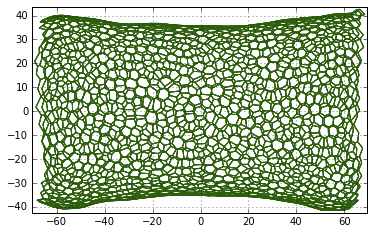

In [10]:
from tyssue.draw.mpl_draw import get_default_draw_specs
draw_specs = get_default_draw_specs()
draw_specs['jv']['visible'] = False
draw_specs['je']['width'] = 0.01


fig, ax = sheet_view(sheet, ['z', 'x'], **draw_specs)
ax.set_xlim(sheet.jv_df.z.min()-1, sheet.jv_df.z.max()+1)
ax.set_ylim(sheet.jv_df.x.min()-1, sheet.jv_df.x.max()+1)

In [ ]:

settings = {
    'norm_factor': 1,
    'minimize': {
        'jac': solver.opt_grad,
        'method': 'L-BFGS-B',
        'options': {'disp': False,
                    'ftol': 1e-6,
                    'gtol': 1e-3},
        }
    }


res = solver.find_energy_min(sheet, geom, model, **settings)
print(res['success'])

In [33]:
center_jes = sheet.je_df[sheet.upcast_srce(sheet.jv_df['z']).abs() < 5].index

sheet.je_df.loc[center_jes, 'line_tension'] = (sheet.je_df.loc[center_jes, 'line_tension'] * 
                                               (3*np.cos(sheet.je_df.loc[center_jes, 'nz'])**2))

fig, ax = plt.subplots()
ax.plot(sheet.upcast_srce(sheet.jv_df['z']), sheet.je_df['line_tension'], '.', alpha=0.2)

In [36]:
settings = {
    'minimize': {
        'options': {'disp':True,
        'gtol':1e-2},
        'jac': solver.opt_grad
        }
    }
res = solver.find_energy_min(sheet,  geom, model, **settings)
print(res['success'])

True


(-47.844877710131968, 47.952048945317763)

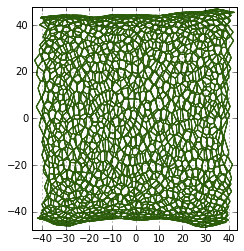

In [37]:
from tyssue.draw.mpl_draw import get_default_draw_specs
draw_specs = get_default_draw_specs()
draw_specs['jv']['visible'] = False
draw_specs['je']['width'] = 0.01


fig, ax = sheet_view(sheet, ['z', 'x'], **draw_specs)
ax.set_xlim(sheet.jv_df.z.min()-1, sheet.jv_df.z.max()+1)
ax.set_ylim(sheet.jv_df.x.min()-1, sheet.jv_df.x.max()+1)

(-20.868982072840954, 20.780561975516239)

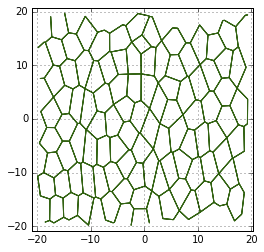

In [38]:
local_mask_jv = (sheet.jv_df.x.abs() < 20) & (sheet.jv_df.z.abs() < 20) & (sheet.jv_df.y > 0)
local_patch_jv = sheet.jv_df[local_mask_jv] 
local_patch_je = sheet.je_df[sheet.upcast_srce(local_mask_jv) & sheet.upcast_trgt(local_mask_jv)]
local_patch_cell = sheet.face_df.loc[np.unique(local_patch_je.face)]
local_datasets = {'jv': local_patch_jv,
                  'je': local_patch_je,
                  'face':local_patch_cell}
local_sheet = Sheet('local', local_datasets)

fig, ax = sheet_view(local_sheet, ['z', 'x'], **draw_specs)
ax.set_xlim(local_sheet.jv_df.z.min()-1, local_sheet.jv_df.z.max()+1)
ax.set_ylim(local_sheet.jv_df.x.min()-1, local_sheet.jv_df.x.max()+1)